In [ ]:
#De La Huerta Avalos Gerardo Cristóbal
#2021630243     6BM1

In [1]:
#importamos dependencias

from sklearn.model_selection import GridSearchCV

%matplotlib inline
%config InlineBackend.figure_format = 'retina'

import matplotlib.pyplot as plt
import numpy as np
import time

import torch
import torch.nn as nn
import torch.nn.functional as F

from torch import optim
from torchvision import datasets, transforms

#helper was developed by Udacity under MIT license
import helper

In [2]:
# Hiper-parámetros

batch_size = 64

In [3]:
# Definimos una transformación de los datos
transform = transforms.Compose([transforms.Resize(32), # escalar a 32
                                transforms.ToTensor(), # convertir a tensores
                                transforms.Normalize([0.5], [0.5])]) #normalizar a media y desv std

# Descargamos el conjunto de entrenamiento y cargamos mediante un dataLoader
trainset = datasets.FashionMNIST('F_MNIST_data/', download=True, train=True, transform=transform)
print(trainset)
trainloader = torch.utils.data.DataLoader(trainset, batch_size, shuffle=True)

# Descargamos el conjunto de validación
testset = datasets.FashionMNIST('F_MNIST_data/', download=True, train=False, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size, shuffle=True)

# Imprimir información estadística del conjunto de datos
print('Train data, number of images: ', len(trainset))
print('Test data, number of images: ', len(testset))

# Nombrar las clases de acuerdo al índice que tienen
classes = ['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat', 
           'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot']

Dataset FashionMNIST
    Number of datapoints: 60000
    Root location: F_MNIST_data/
    Split: Train
    StandardTransform
Transform: Compose(
               Resize(size=32, interpolation=bilinear, max_size=None, antialias=warn)
               ToTensor()
               Normalize(mean=[0.5], std=[0.5])
           )
Train data, number of images:  60000
Test data, number of images:  10000


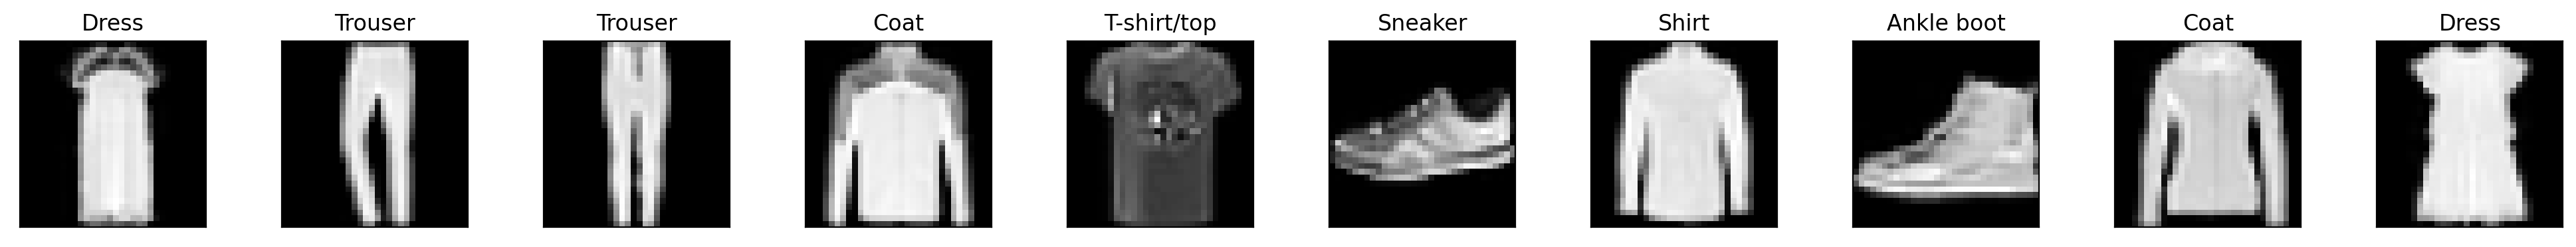

In [4]:
# Obtener un lote de ejemplos
dataiter = iter(trainloader)
images, labels = next(dataiter)
images = images.numpy()

display_size = 10

# Graficar los ejemplos junto a las clases que le corresponden
fig = plt.figure(figsize=(25, 4))
for idx in np.arange(display_size):
    ax = fig.add_subplot(2, display_size, idx+1, xticks=[], yticks=[])
    ax.imshow(np.squeeze(images[idx]), cmap='gray')
    ax.set_title(classes[labels[idx]])

In [5]:
# Implementación de LeNet5
class LeNet5(nn.Module):
    def __init__(self, n_clases):
        '''
        Construimos la estructura de LeNet5
        
        '''
        super(LeNet5, self).__init__()
        
        # De acuerdo al artículo de LeCun La primera capa está compuesta por 6 kernels de 5x5
        self.conv1 = nn.Conv2d(1, 6, 5) # 1 canal de entrada 6 feature maps de salida, kernels de 5x5
        
        # Después tenemos una capa avgpooling
        # kernel_size=2, stride=2
        self.pool1 = nn.AvgPool2d(2, 2)
        
        # Agregamos otra capa convolucional con 16 kernels de 5 x 5
        self.conv2 = nn.Conv2d(6, 16, 5)
        
        # Avgpooling
        self.pool2 = nn.AvgPool2d(2, 2)

        # Tercera convolución para 120 kernels 5 x 5

        self.conv3 = nn.Conv2d(16, 120, 5)
        
        # Capas totalmente conectadas
        self.fc1 = nn.Linear(16*5*5, 120)
        self.fc2 = nn.Linear(120, 84)
        #self.fc3 = nn.Linear(84, n_clases)     -> Esta capa completamente conectada se supone que no debe estar, por eso la comento
    
    def forward(self, x):
        '''
        Definimos el pase frontal (forward pass)
        '''
        # Agregamos los tanh
        x = self.pool1(F.tanh(self.conv1(x)))
        #print(x.size())
        x = self.pool2(F.tanh(self.conv2(x)))

        # prep for linear layer by flattening the feature maps into feature vectors
        x = x.view(x.size(0), -1)
        # capas lineales
        x = F.tanh(self.fc1(x))
        x = F.softmax(self.fc2(x))
        #x = self.fc3(x)
        
        return F.log_softmax(x, dim=1)

In [6]:
# Instanciar la red
model = LeNet5(10)
# Definir la función de costo (critetio de optimización)
criterion = nn.NLLLoss()
# Instanciar optimizador
optimizer = optim.Adam(model.parameters(), lr=0.0001)

print(model.parameters)

<bound method Module.parameters of LeNet5(
  (conv1): Conv2d(1, 6, kernel_size=(5, 5), stride=(1, 1))
  (pool1): AvgPool2d(kernel_size=2, stride=2, padding=0)
  (conv2): Conv2d(6, 16, kernel_size=(5, 5), stride=(1, 1))
  (pool2): AvgPool2d(kernel_size=2, stride=2, padding=0)
  (conv3): Conv2d(16, 120, kernel_size=(5, 5), stride=(1, 1))
  (fc1): Linear(in_features=400, out_features=120, bias=True)
  (fc2): Linear(in_features=120, out_features=84, bias=True)
)>


In [9]:
#antes de realizar el entrenamiento de la red neuronal, vamos primero a realizar la busqueda del os mejores hiperparámetros a través del metodo de busqueda por rejilla

from sklearn.neural_network import MLPClassifier

MLP_model = MLPClassifier(random_state=2021)
print (MLP_model)

MLPClassifier(random_state=2021)


In [10]:
#Definimos el espacio de busqueda de hiperparámetros

search_space = {
    'hidden_layer_sizes': [(64,)],
    'activation': ['relu', 'tanh'],
    'solver': ['sgd', 'adam'],
    'alpha': [0.0001, 0.001, 0.01]
}

In [11]:
gs = GridSearchCV(
    estimator=MLP_model,
    param_grid=search_space,
    scoring=["r2", "neg_root_mean_squared_error"],
    refit="r2",
    cv=2,
    verbose=4,
    error_score='raise'
)

In [12]:
#realizamos la busqueda de los mejores hiperparámetros

grid_result = gs.fit(X=trainset.data.reshape(trainset.data.shape[0], -1), y=trainset.targets)

Fitting 2 folds for each of 12 candidates, totalling 24 fits
[CV 1/2] END activation=relu, alpha=0.0001, hidden_layer_sizes=(64,), solver=sgd; neg_root_mean_squared_error: (test=-2.856) r2: (test=0.011) total time= 1.7min
[CV 2/2] END activation=relu, alpha=0.0001, hidden_layer_sizes=(64,), solver=sgd; neg_root_mean_squared_error: (test=-2.887) r2: (test=-0.011) total time= 1.8min
[CV 1/2] END activation=relu, alpha=0.0001, hidden_layer_sizes=(64,), solver=adam; neg_root_mean_squared_error: (test=-1.452) r2: (test=0.744) total time= 4.8min
[CV 2/2] END activation=relu, alpha=0.0001, hidden_layer_sizes=(64,), solver=adam; neg_root_mean_squared_error: (test=-1.387) r2: (test=0.767) total time= 3.7min
[CV 1/2] END activation=relu, alpha=0.001, hidden_layer_sizes=(64,), solver=sgd; neg_root_mean_squared_error: (test=-3.003) r2: (test=-0.093) total time=  41.1s
[CV 2/2] END activation=relu, alpha=0.001, hidden_layer_sizes=(64,), solver=sgd; neg_root_mean_squared_error: (test=-2.867) r2: (te

In [7]:
# Información de la red
model

LeNet5(
  (conv1): Conv2d(1, 6, kernel_size=(5, 5), stride=(1, 1))
  (pool1): AvgPool2d(kernel_size=2, stride=2, padding=0)
  (conv2): Conv2d(6, 16, kernel_size=(5, 5), stride=(1, 1))
  (pool2): AvgPool2d(kernel_size=2, stride=2, padding=0)
  (conv3): Conv2d(16, 120, kernel_size=(5, 5), stride=(1, 1))
  (fc1): Linear(in_features=400, out_features=120, bias=True)
  (fc2): Linear(in_features=120, out_features=84, bias=True)
)

In [13]:
print(grid_result.best_estimator_)

MLPClassifier(hidden_layer_sizes=(64,), random_state=2021)


In [14]:
print(grid_result.best_score_)

0.7557131313131313


In [15]:
print(grid_result.best_params_)

{'activation': 'relu', 'alpha': 0.0001, 'hidden_layer_sizes': (64,), 'solver': 'adam'}


In [16]:
print(grid_result.best_index_)

1


In [17]:
#una vez realizada la busqueda por rejilla, usamos pandas para exportar a un csv los resultados de las convinaciones probadas

import pandas as pd

df = pd.DataFrame(grid_result.cv_results_)
df = df.sort_values("rank_test_r2")
df.to_csv("tercer_Grid_Search.csv")

In [8]:
# Implementamos una función de evaluación
def validation(model, testloader, criterion):
    test_loss = 0
    accuracy = 0
    for images, labels in testloader:

        #images.resize_(images.shape[0], 784)

        output = model.forward(images)
        test_loss += criterion(output, labels).item()

        ps = torch.exp(output)
        equality = (labels.data == ps.max(dim=1)[1])
        accuracy += equality.type(torch.FloatTensor).mean()
    
    return test_loss, accuracy

In [9]:
from torch.autograd import Variable

# Antes del descenso por gradiente y el entrenamiento 
# verificaremos que la red está bien implementada a través verificar la exactitud que tiene sin haber sido entrenada.

correct = 0
total = 0

# Iterate through test dataset
for images, labels in testloader:
    
    # warp input images in a Variable wrapper
    images = Variable(images)

    # forward pass to get outputs
    # the outputs are a series of class scores
    outputs = model(images)

    # get the predicted class from the maximum value in the output-list of class scores
    _, predicted = torch.max(outputs.data, 1)

    # count up total number of correct labels
    # for which the predicted and true labels are equal
    total += labels.size(0)
    correct += (predicted == labels).sum()

# calculate the accuracy
accuracy = 100 * correct.numpy() / total

# print it out!
print('Porcentaje de exactitud antes de entrenar: ', accuracy)

/tmp/ipykernel_4283/3473914208.py:45: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  x = F.softmax(self.fc2(x))


Porcentaje de exactitud antes de entrenar:  0.47


In [10]:
#Realizamos el entrenamiento de la red neuronal Lenet5 con los hiperparámetros que obtuvimos anteriormente

from torch.autograd import Variable

# Hiperparámetros

epochs = 100
steps = 0
running_loss = 0
print_every = 40


# Descenso por gradiente
for e in range(epochs):
    # Cambiamos a modo entrenamiento
    model.train()
    
    for images, labels in trainloader:
        steps += 1
        
        # Aplanar imágenes a un vector de 784 elementos
        # images.resize_(images.size()[0], 784)
        
        optimizer.zero_grad()
        
        # wrap them in a torch Variable
        images, labels = Variable(images), Variable(labels)       
        
        output = model(images)
        loss = criterion(output, labels)
        # Backpropagation
        loss.backward()
        # Optimización
        optimizer.step()
        
        running_loss += loss.item()
        
        if steps % print_every == 0:
            # Cambiamos a modo de evaluación
            model.eval()
            
            # Apagamos los gradientes, reduce memoria y cálculos
            with torch.no_grad():
                test_loss, accuracy = validation(model, testloader, criterion)
                
            print("Epoch: {}/{}.. ".format(e+1, epochs),
                  "Training Loss: {:.3f}.. ".format(running_loss/print_every),
                  "Test Loss: {:.3f}.. ".format(test_loss/len(testloader)),
                  "Test Accuracy: {:.3f}".format(accuracy/len(testloader)))
            
            running_loss = 0
            
            # Make sure training is back on
            model.train()

/tmp/ipykernel_4283/3473914208.py:45: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  x = F.softmax(self.fc2(x))


Epoch: 1/100..  Training Loss: 4.428..  Test Loss: 4.422..  Test Accuracy: 0.350
Epoch: 1/100..  Training Loss: 4.399..  Test Loss: 4.355..  Test Accuracy: 0.240
Epoch: 1/100..  Training Loss: 4.295..  Test Loss: 4.236..  Test Accuracy: 0.342
Epoch: 1/100..  Training Loss: 4.181..  Test Loss: 4.152..  Test Accuracy: 0.361
Epoch: 1/100..  Training Loss: 4.130..  Test Loss: 4.097..  Test Accuracy: 0.426
Epoch: 1/100..  Training Loss: 4.062..  Test Loss: 4.046..  Test Accuracy: 0.470
Epoch: 1/100..  Training Loss: 4.022..  Test Loss: 4.014..  Test Accuracy: 0.481
Epoch: 1/100..  Training Loss: 3.989..  Test Loss: 3.986..  Test Accuracy: 0.523
Epoch: 1/100..  Training Loss: 3.981..  Test Loss: 3.962..  Test Accuracy: 0.537
Epoch: 1/100..  Training Loss: 3.946..  Test Loss: 3.939..  Test Accuracy: 0.585
Epoch: 1/100..  Training Loss: 3.934..  Test Loss: 3.918..  Test Accuracy: 0.598
Epoch: 1/100..  Training Loss: 3.923..  Test Loss: 3.901..  Test Accuracy: 0.613
Epoch: 1/100..  Training Los

/tmp/ipykernel_4283/3634788098.py:7: UserWarning: volatile was removed and now has no effect. Use `with torch.no_grad():` instead.
  preds = np.squeeze(model(Variable(images, volatile=True)).data.max(1, keepdim=True)[1].numpy())
/tmp/ipykernel_4283/3473914208.py:45: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  x = F.softmax(self.fc2(x))


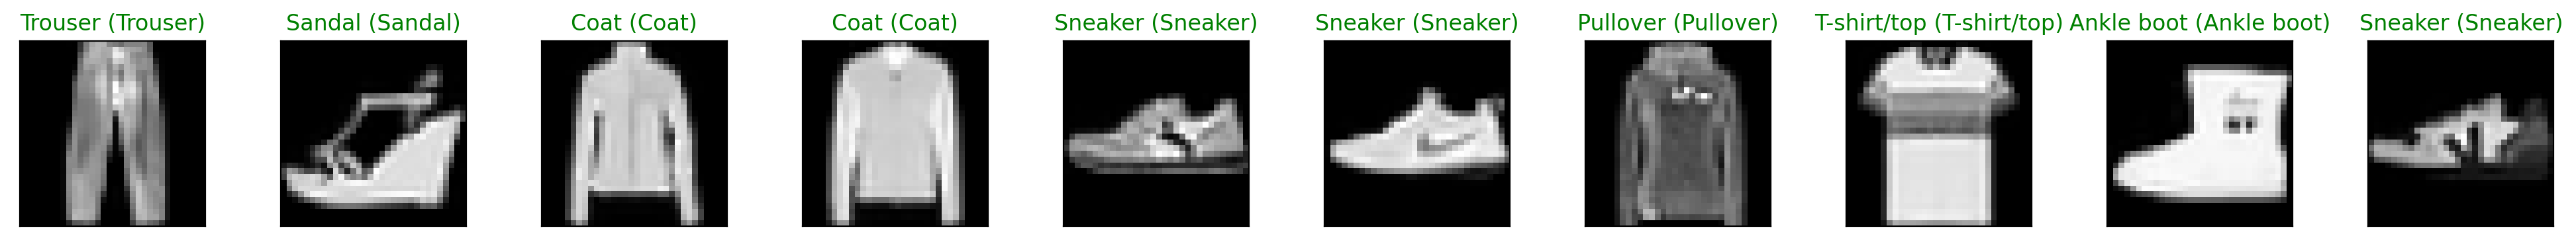

In [12]:
#Desplegamos el resultado de nuestro entrenamiento
# obtain one batch of test images
display_size = 10

dataiter = iter(testloader)
images, labels = next(dataiter)
# get predictions
preds = np.squeeze(model(Variable(images, volatile=True)).data.max(1, keepdim=True)[1].numpy())
images = images.numpy()

# plot the images in the batch, along with predicted and true labels
fig = plt.figure(figsize=(25, 4))
for idx in np.arange(display_size):
    ax = fig.add_subplot(2, display_size, idx+1, xticks=[], yticks=[])
    ax.imshow(np.squeeze(images[idx]), cmap='gray')
    ax.set_title("{} ({})".format(classes[preds[idx]], classes[labels[idx]]),
                 color=("green" if preds[idx]==labels[idx] else "red"))